# Install Transformers Library

In [1]:
!pip install transformers==2.7.0

     |████████████████████████████████| 544 kB 11.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.6 MB/s 
     |████████████████████████████████| 5.6 MB 17.6 MB/s 
     |████████████████████████████████| 895 kB 54.6 MB/s 
     |████████████████████████████████| 131 kB 51.0 MB/s 
     |████████████████████████████████| 8.0 MB 39.3 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 138 kB 50.6 MB/s 
     |████████████████████████████████| 127 kB 52.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, RobertaTokenizerFast
# from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup


# specify GPU
device = torch.device("cuda")

In [12]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset

In [13]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/small_dataset1.xlsx")
df.head()

,class,Symptom Severity,Delusion Score,text
0,patient,72,12,I would wake up greet my pet/friend use the ...
1,patient,92,22,"On a average Sunday I wake up, brush my teet..."
2,patient,64,4,Well This white lady moved in my hood an she...
3,control,0,0,sometimes when my family comes around and th...
4,patient,79,10,The thing that makes me the angriest is when...


In [14]:
df.shape

(373, 4)

In [15]:
df['class'] = df['class'].replace(['patient','control'],[0,1])

In [16]:
# check class distribution
df['class'].value_counts(normalize = True)

1    0.509383
0    0.490617
Name: class, dtype: float64

# Split train dataset into train, validation and test sets

In [17]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['class'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [18]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('roberta-base')

# Load the BERT tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

RobertaTokenizerFast has an issue when working on mask language modeling where it introduces an extra encoded space before the mask token.See https://github.com/huggingface/transformers/pull/2778 for more information.


In [19]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [20]:
# output
print(sent_id)

{'input_ids': [[0, 9226, 16, 10, 741, 2399, 1421, 35950, 2], [0, 1694, 40, 2051, 12, 90, 4438, 10, 741, 2399, 1421, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

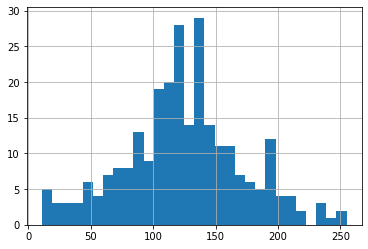

In [21]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [22]:
max_seq_len = 120

In [23]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [24]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 25

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [26]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [27]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [28]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [49]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

# Find Class Weights

In [50]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.01953125 0.98120301]


In [51]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 40

# Fine-Tune BERT

In [52]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [53]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [54]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 40

Evaluating...

Training Loss: 0.681
Validation Loss: 0.683

 Epoch 2 / 40

Evaluating...

Training Loss: 0.680
Validation Loss: 0.683

 Epoch 3 / 40

Evaluating...

Training Loss: 0.675
Validation Loss: 0.686

 Epoch 4 / 40

Evaluating...

Training Loss: 0.674
Validation Loss: 0.686

 Epoch 5 / 40

Evaluating...

Training Loss: 0.673
Validation Loss: 0.685

 Epoch 6 / 40

Evaluating...

Training Loss: 0.678
Validation Loss: 0.681

 Epoch 7 / 40

Evaluating...

Training Loss: 0.674
Validation Loss: 0.681

 Epoch 8 / 40

Evaluating...

Training Loss: 0.673
Validation Loss: 0.684

 Epoch 9 / 40

Evaluating...

Training Loss: 0.677
Validation Loss: 0.689

 Epoch 10 / 40

Evaluating...

Training Loss: 0.673
Validation Loss: 0.684

 Epoch 11 / 40

Evaluating...

Training Loss: 0.672
Validation Loss: 0.679

 Epoch 12 / 40

Evaluating...

Training Loss: 0.671
Validation Loss: 0.680

 Epoch 13 / 40

Evaluating...

Training Loss: 0.669
Validation Loss: 0.686

 Epoch 14 / 40

Eval

# Load Saved Model

In [55]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [56]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [57]:
preds

array([[-0.72158915, -0.6654918 ],
       [-0.6537525 , -0.7341577 ],
       [-0.761688  , -0.62900436],
       [-0.64238006, -0.74663   ],
       [-0.65183645, -0.73623836],
       [-0.6605763 , -0.7268148 ],
       [-0.66379285, -0.7233894 ],
       [-0.6285291 , -0.762231  ],
       [-0.6539481 , -0.7339458 ],
       [-0.5850502 , -0.81436145],
       [-0.646254  , -0.7423481 ],
       [-0.55972147, -0.8471568 ],
       [-0.6595146 , -0.7279504 ],
       [-0.64441013, -0.74438167],
       [-0.6695276 , -0.7173382 ],
       [-0.5737231 , -0.82879245],
       [-0.6304428 , -0.76004803],
       [-0.7061253 , -0.68033534],
       [-0.68302304, -0.7033749 ],
       [-0.78832424, -0.6062468 ],
       [-0.7037085 , -0.6826963 ],
       [-0.6931017 , -0.6931926 ],
       [-0.7588241 , -0.6315192 ],
       [-0.67242324, -0.71430963],
       [-0.67121184, -0.7155745 ],
       [-0.7417139 , -0.6468304 ],
       [-0.65280396, -0.73518664],
       [-0.68241644, -0.70399445],
       [-0.63926554,

In [58]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75        28
           1       0.87      0.46      0.60        28

    accuracy                           0.70        56
   macro avg       0.75      0.70      0.68        56
weighted avg       0.75      0.70      0.68        56



In [60]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,26,2
1,15,13
